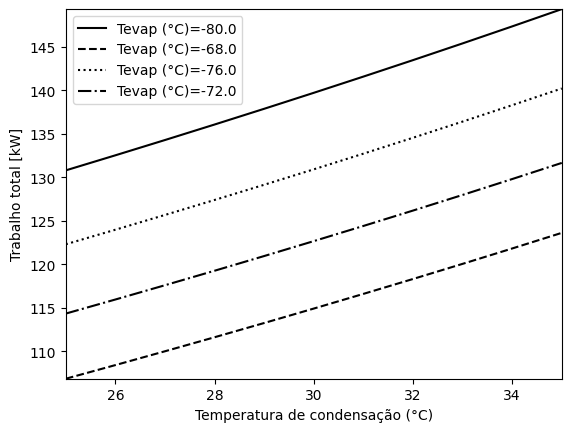

In [2]:
from CoolProp.CoolProp import PropsSI as COOLPROP
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import get_test_data
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

#Listas
T1_lista = []
T11_lista = []
Wcomp_total_lista = []
COP_lista = []
cont = []

#temperaturas de condensação
for i in range (25, 36, 1):
    cont.append(i+273.15)

#Parâmentros
Pfrig = 120 * 1000
T5 = -24 + 273.15 #[K]
T12 = -29 + 273.15 #[K] 
fluid_high = 'R600'
fluid_low = 'R170'
N = 0.7 #Eficiência isentrópica
drop_suc = 0 #[Pa]
drop_desc = 0 #[Pa]
DeltaT = 0.01 #[°C]

#Pressão crítica do fluido do ciclo de alta pressão
P_crit_high = COOLPROP('PCRIT', fluid_high)

#Ciclo de baixa pressão
P5 = COOLPROP('P', 'T', T5, 'Q', 0, fluid_low)
h5 = COOLPROP('H', 'T', T5, 'Q', 0, fluid_low)
h6 = h5
P4 = P5

#Ciclo de alta pressão
P12 = COOLPROP('P', 'T', T12, 'Q', 0.3, fluid_high)
P9 = P12
T9 = COOLPROP('T', 'P', P9, 'Q', 1, fluid_high)
h9 = COOLPROP('H', 'T', T9, 'Q', 1, fluid_high)
he = h9
Pe = P9 - drop_suc
Te = COOLPROP ('T', 'H', he, 'P', Pe, fluid_high)
Pf = Pe
Tf = Te + DeltaT
hf = COOLPROP('H', 'T', Tf, 'P', Pf, fluid_high)
sf = COOLPROP('S', 'T', Tf, 'P', Pf, fluid_high)

#variação das temperaturas de evaporação e condensação
for T1 in range (-80, -67, 4):
    #Ciclo de baixa pressão
    T1 = T1 + 273.15
    P1 = COOLPROP('P', 'T', T1, 'Q', 1, fluid_low)
    h1 = COOLPROP('H', 'T', T1, 'Q', 1, fluid_low)
    #Pressão intermediária
    P_int =  (P1 * P5) ** 0.5
    P6 = P_int
    P3 = P_int
    P7 = P_int
    P2 = P_int
    r1 = P2/P1
    r2 = P4/P3
    h7 = COOLPROP('H', 'P', P7, 'Q', 0, fluid_low)
    h8 = h7
    h3 = COOLPROP('H', 'P', P3, 'Q', 1, fluid_low)
    #CBP
    ha = h1
    Pa = P1 - drop_suc
    Ta = COOLPROP('T', 'H', ha, 'P', Pa, fluid_low)
    Pb = Pa
    Tb = Ta + DeltaT
    hb = COOLPROP('H', 'T', Tb, 'P', Pb, fluid_low)
    sb = COOLPROP('S', 'T', Tb, 'P', Pb, fluid_low)
    Pc = P2 + drop_desc
    Sc_ideal = sb     
    hc_ideal = COOLPROP('H', 'S', Sc_ideal , 'P', Pc, fluid_low)
    hc_real = (hc_ideal - hb)/N + hb
    h2 = hc_real
    m_CBP = Pfrig / (h1 - h8)
    #Trabalho específico do CBP
    w_CBP = hc_real - hb
    #Trabalho do CBP
    W_CBP = m_CBP * w_CBP
    #CAP
    hw = h3
    Pw = P3 - drop_suc
    Tw = COOLPROP('T', 'H', hw, 'P', Pw, fluid_low)
    Px = Pw
    Tx = Tw + DeltaT
    hx = COOLPROP('H', 'P', Px, 'T', Tx, fluid_low)
    sx = COOLPROP('S', 'P', Px, 'T', Tx, fluid_low)
    P4 = P5
    Py = P4 + drop_desc
    sy_ideal = sx
    hy_ideal = COOLPROP('H', 'P', Py, 'S', sy_ideal, fluid_low)
    hy_real = (hy_ideal - hx)/N + hx
    h4 = hy_real
    m_CAP = m_CBP * (h7 - h2) / (h6 - h3)
    #Trabalho específico do CAP
    w_CAP = hy_real - hx
    #Trabalho do CAP
    W_CAP = m_CAP * w_CAP
    #Trabalho total no ciclo de baixa pressão
    W_low_total = W_CAP + W_CBP
    #Calor trocado no trocador central
    Qcond_low =  m_CAP * (h4 - h5)
    for T11 in cont:
        #Ciclo de alta pressão
        Qevap_high = Qcond_low
        P11 = COOLPROP('P', 'T', T11, 'Q', 0, fluid_high)
        P10 = P11
        r3 = P10/P9
        Pg = P10 + drop_desc
        h11 = COOLPROP('H', 'T', T11, 'Q', 0, fluid_high)
        h12 = h11
        m_flow_high = Qevap_high / (h9 - h12)
        sg_ideal = sf
        hg_ideal = COOLPROP('H', 'P', Pg, 'S', sg_ideal, fluid_high)
        hg_real = (hg_ideal - hf)/N + hf
        
        #Verificação da pressão crítica
        if P_crit_high > P10:
            T1_lista.append(T1 - 273.15)
            T11_lista.append(T11 - 273.15)
            #Trabalho específico do compressor do ciclo de alta rpessão
            w_high = hg_real - hf
            #Trabalho do compressor do ciclo de alta pressão
            Wcomp_high = m_flow_high * w_high
            #Trabalho total
            Wcomp_total = Wcomp_high + W_low_total
            Wcomp_total_lista.append(Wcomp_total / 1000)
            #COP
            COP = Pfrig / Wcomp_total
            COP_lista.append(COP)
        else:
            print ('A pressão P10 = {:0.2f} kPa (T1 = {:0.2f}°C, T11 = {:0.2f}°C) é maior do que a ' 
               'pressão crítica do {} logo o ponto não foi incluído no gráfico'
                   .format(P10/1000,T1-273.15,T11-273.15,fluid_high))
    
x = T11_lista
z = T1_lista
y = Wcomp_total_lista

# Define um dicionário que mapeia os valores de z para estilos de linha diferentes
z_linestyles = {z_val: linestyle for z_val, linestyle in zip(set(z), ['-','--', ':', '-.'])}

# Cria uma figura com um gráfico 2D
fig, ax = plt.subplots()

# Itera sobre os valores únicos de z
for z_val in set(z):
    # Seleciona os pontos correspondentes a z_val
    x_val = [x[i] for i in range(len(x)) if z[i] == z_val]
    y_val = [y[i] for i in range(len(y)) if z[i] == z_val]

    # Plota os pontos com uma linha ligando eles
    ax.plot(x_val, y_val, linestyle=z_linestyles[z_val], color='black', label=f'Tevap (°C)={z_val}')

# Define os limites dos eixos X e Y
ax.set_xlim(min(x), max(x))
ax.set_ylim(min(y), max(y))

# Define os rótulos dos eixos X e Y
ax.set_xlabel('Temperatura de condensação (°C)')
ax.set_ylabel('Trabalho total [kW]')

# Adiciona a legenda
ax.legend()


# Mostra o gráfico
plt.show()

